# Testing Colormaps

In this notebook we implement some of Peter Kovesi's proposed colormap tests, and try them out on some new maps. In particular, we're interested in the performance of:

1. Diverging color tables made from two concatenated converging color tables 
2. A "random linear" color table, designed to look like a linear grayscale when printed in black and white, but incomprehensible when seen on a color display.


### Requirements

You'll need `matplotlib`, but that's about it.

In [1]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib._cm import cubehelix
import numpy as np
import matplotlib.pyplot as plt

from testcard import *

%matplotlib inline

## Test Colormap Data

Peter Karpov provides color map data on his website, [here](http://inversed.ru/Blog_2.htm). These are checked in to the `data` folder of this repository.

In [2]:
_hesperia_data = np.loadtxt("data/hesperia.csv", delimiter=",", skiprows=4).tolist()
_laguna_data = np.loadtxt("data/laguna.csv", delimiter=",", skiprows=4).tolist()
_lacerta_data = np.loadtxt("data/lacerta.csv", delimiter=",", skiprows=4).tolist()
_mod_plasma_data = np.loadtxt("data/mod_plasma.csv", delimiter=",", skiprows=4).tolist()

## Diverging Colormaps

First, let's try constructing a diverging color map from concatenating two converging color maps, back to back:

In [3]:
one = _hesperia_data
two = _laguna_data

In [4]:
# Concatenate maps "one" and "two", back to back so that the central value
# is de-emphasized, and make the inverse scale "_r" as well:
center_emph = ListedColormap((one[::-1][:192] + two[1:][64:])[10:-10], name="center_emph")
center_emph_r = ListedColormap(center_emph.colors[::-1], name="center_emph_r")
plt.register_cmap(cmap=center_emph)
plt.register_cmap(cmap=center_emph_r)

# Now do the same thing, but to emphasize the central value instead:
center_deemph = ListedColormap((one[:-1][64:] + two[::-1][:192])[20:-20], name="center_deemph")
center_deemph_r = ListedColormap(center_deemph.colors[::-1], name="center_deemph_r")
plt.register_cmap(cmap=center_emph)
plt.register_cmap(cmap=center_emph_r)

Now make a testcard plot for each one.

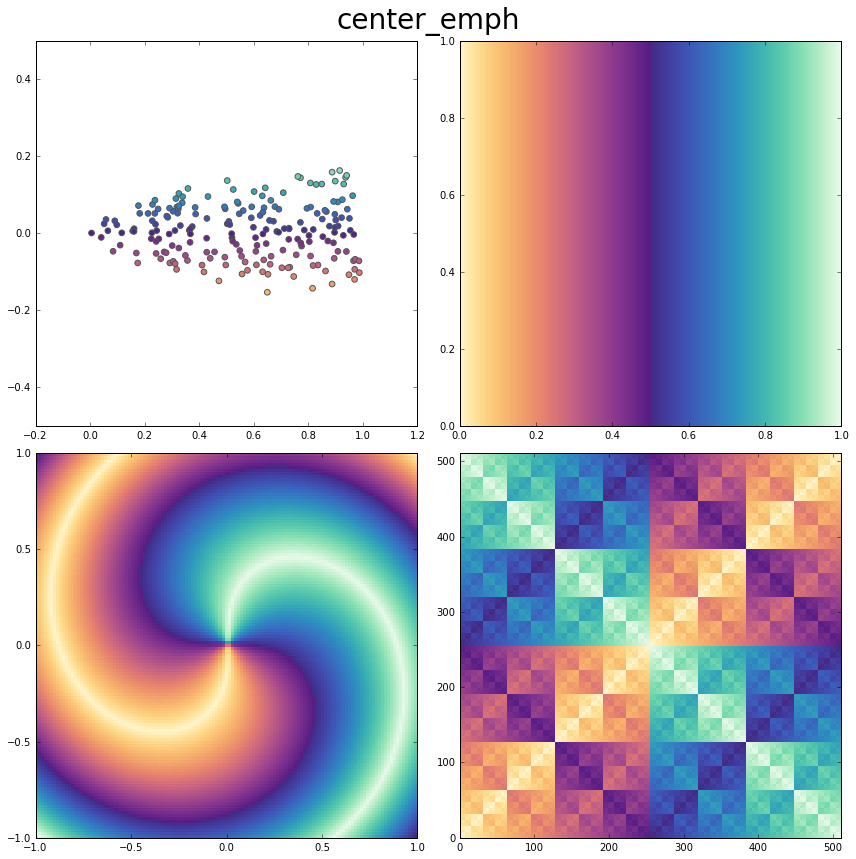

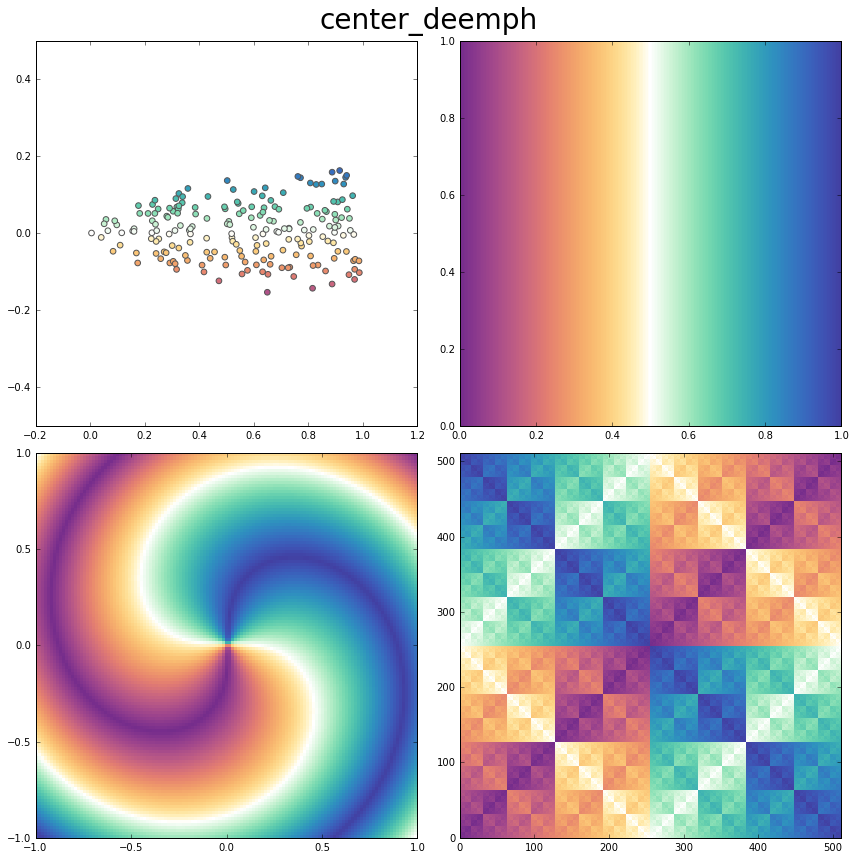

In [5]:
for cmap in [center_emph, center_deemph]:
    fig = testcard(cmap)
    fig.savefig("{}.png".format(cmap.name))

## Random Linear

Goal: find a color map that appears to be a linear grayscale when viewed (or printed) in black and white, but is as colorful as possible when viewed in color.

### 1. Fast `cubehelix`

Could we implement this cheaply by using the `cubehelix` color map, but have it wind so fast that the hue is effectively random?

In [26]:
# Make a cubehelix color map, and re-register it as "fast_cubehelix".

# First get the cubehelix color table, with some large number of rotations:
forward = cubehelix(gamma=1.0, s=0.5, r=-37*3.141592654, h=1.0)

# Now register this as a listed color map:
fast_cubehelix = LinearSegmentedColormap("fast_cubehelix", forward, 256)
plt.register_cmap(cmap=fast_cubehelix)

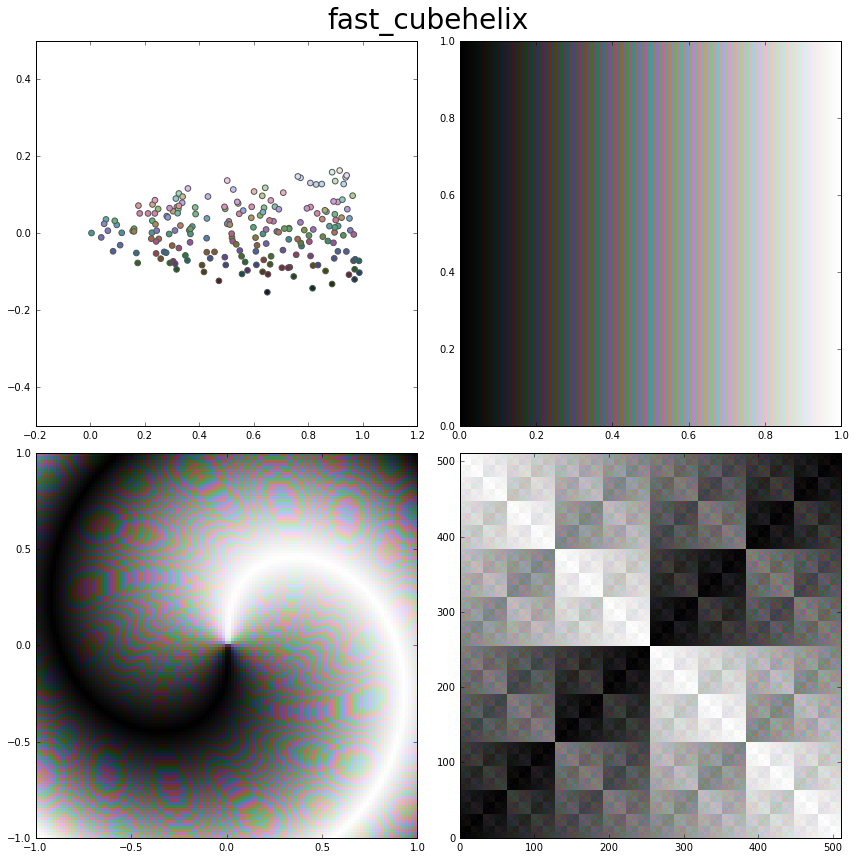

In [27]:
fig = testcard(fast_cubehelix)
fig.savefig('fast_cubehelix.png')

So this does *not* work, but in a fairly amusing way: the helical path through the RGB cube is too regular, even when it's a very tight spiral, and you get interference effects. 

### 2. Random Sampling

Let's try making RGB arrays with the same linear amplitude as `cubehelix`, but otherwise sampling "randomly". 

In [42]:
def random_linear():

    reverse = False
    minSat = 1.2
    maxSat = 1.2
    nlev = 256
    gamma = 1.0
    
    # Set up the amplitude array: 
    fract = np.linspace(0.0, 1.0, 256)
    # fract = fract**gamma
    # satar = np.linspace(minSat, maxSat, nlev)
    # amp = satar * fract * (1. - fract) / 2.
    amp = fract
    
    # Compute the RGB vectors by sampling in theta and phi
    costheta = np.random.random(nlev)
    theta = np.arccos(costheta)
    phi = np.random.random(nlev) * np.pi / 2.0
    
    red = amp * np.sin(theta)
    grn = amp *      costheta * np.sin(phi)
    blu = amp *      costheta * np.cos(phi)
    
    
    
    # Find where RGB are outside the range [0,1], and clip
    red[np.where((red > 1.))] = 1.
    grn[np.where((grn > 1.))] = 1.
    blu[np.where((blu > 1.))] = 1.

    red[np.where((red < 0.))] = 0.
    grn[np.where((grn < 0.))] = 0.
    blu[np.where((blu < 0.))] = 0.

    # THIS IS NOT RIGHT - THIS ACTION DOES NOT PRESERVE THE GRAYSCALE. 
    
    
    
    # Optional color reverse
    if reverse is True:
        red = red[::-1]
        blu = blu[::-1]
        grn = grn[::-1]

    # Put in to tuple & dictionary structures needed
    rr = []
    bb = []
    gg = []
    for k in range(0, int(nlev)):
        rr.append((float(k) / (nlev - 1.), red[k], red[k]))
        bb.append((float(k) / (nlev - 1.), blu[k], blu[k]))
        gg.append((float(k) / (nlev - 1.), grn[k], grn[k]))

    cdict = {'red': rr, 'blue': bb, 'green': gg}
    return LinearSegmentedColormap('random_linear', cdict)

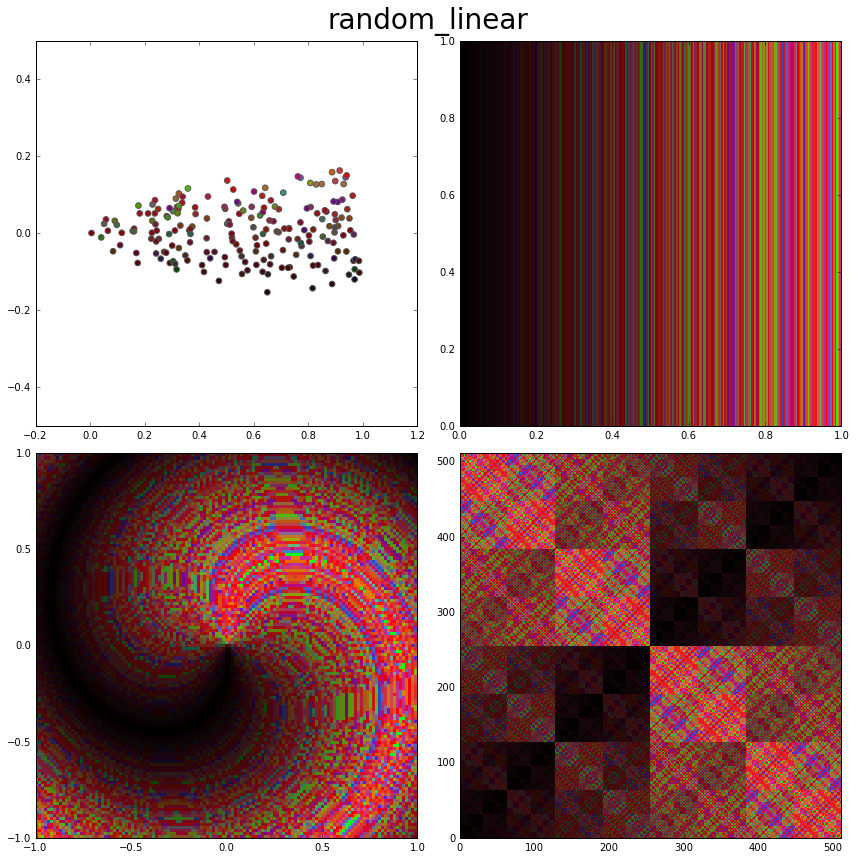

In [43]:
cmap = random_linear()
plt.register_cmap(cmap=cmap)
fig = testcard(cmap)
fig.savefig('random_linear.png')